
=== Performance Metrics (Mean ± Std) ===

--- MC ---
Rise Time (s) (Mean): 0.1694
Rise Time (s) (Std): 0.0245
Settling Time (s) (Mean): 1.5046
Settling Time (s) (Std): 0.2909
Peak Overshoot (%) (Mean): 41.3896
Peak Overshoot (%) (Std): 3.6129
Steady-State Error (Mean): 0.8006
Steady-State Error (Std): 0.8595

--- LHS ---
Rise Time (s) (Mean): 0.1685
Rise Time (s) (Std): 0.0454
Settling Time (s) (Mean): 1.4304
Settling Time (s) (Std): 0.4631
Peak Overshoot (%) (Mean): 40.9124
Peak Overshoot (%) (Std): 6.5645
Steady-State Error (Mean): 1.3228
Steady-State Error (Std): 2.4024

--- IS ---
Rise Time (s) (Mean): 0.1696
Rise Time (s) (Std): 0.0126
Settling Time (s) (Mean): 1.5077
Settling Time (s) (Std): 0.1503
Peak Overshoot (%) (Mean): 41.5693
Peak Overshoot (%) (Std): 1.8223
Steady-State Error (Mean): 0.6841
Steady-State Error (Std): 0.6239


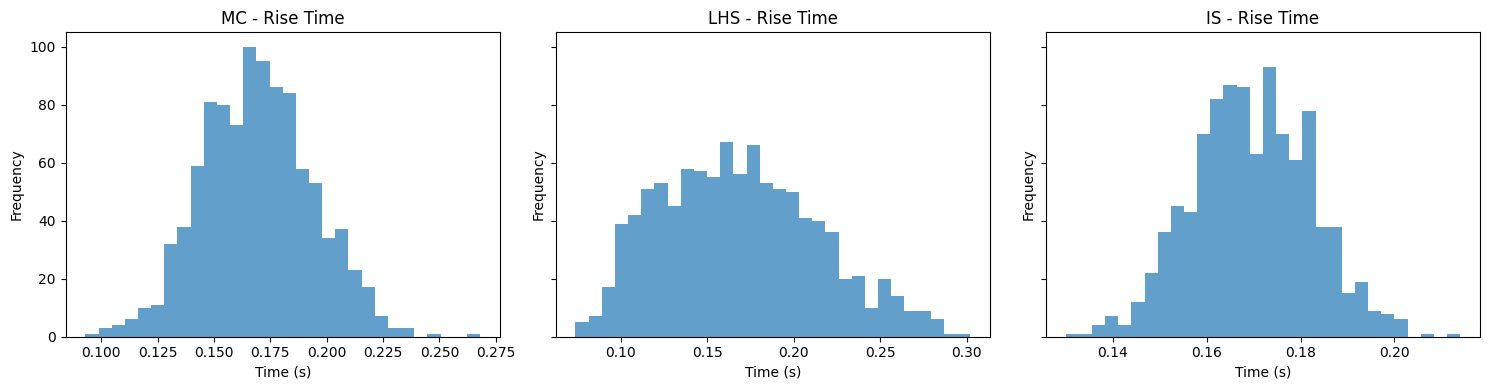

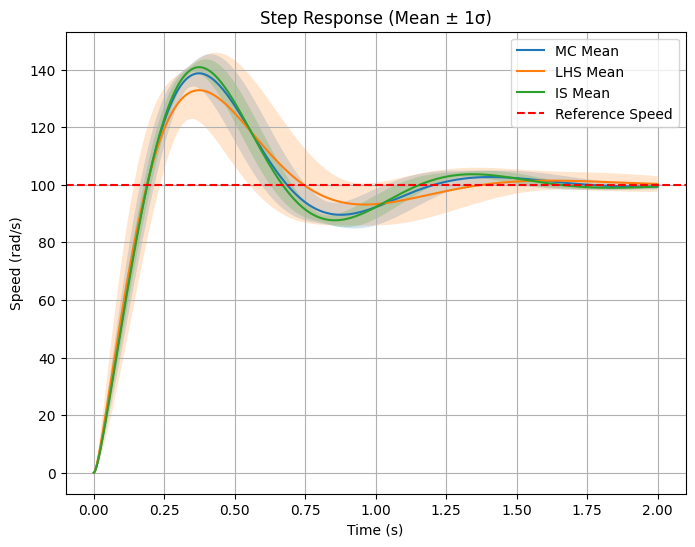

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.stats import qmc

###############################################################################
# 1) DC Motor Model and PID Controller
###############################################################################
class DCMotorSimulator:
    """
    Simulates a DC motor governed by:
      Va = R*ia + L*(dia/dt) + Kb*omega   (Eq. 1)
      J*(domega/dt) = Kt*ia - B*omega    (Eq. 2)
    
    With a PID controller that sets Va(t) = Kp*e(t) + Ki*∫e(t)dt + Kd*de(t)/dt  (Eq. 3)
    where e(t) = (omega_ref - omega).
    """
    def __init__(self, 
                 R, L, Kb, Kt, J, B, 
                 Kp=1.0, Ki=10.0, Kd=0.01, 
                 omega_ref=100.0):
        """
        Parameters
        ----------
        R, L, Kb, Kt, J, B : float
            Motor parameters:
              R = resistance, L = inductance, Kb = back-EMF const,
              Kt = torque const, J = inertia, B = damping
        Kp, Ki, Kd : float
            PID gains
        omega_ref : float
            Desired reference speed (rad/s)
        """
        self.R = R
        self.L = L
        self.Kb = Kb
        self.Kt = Kt
        self.J = J
        self.B = B
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.omega_ref = omega_ref
        
        # For convenience, store parameters in a list or tuple if needed
        self.params = (R, L, Kb, Kt, J, B)
        
    def _motor_odes(self, t, y, Va):
        """
        ODE system for the DC motor:
          y = [ia, omega]
          Va = control voltage from PID
        """
        ia, omega = y
        R, L, Kb, Kt, J, B = self.params
        
        dia_dt = (Va - R*ia - Kb*omega) / L
        domega_dt = (Kt*ia - B*omega) / J
        return [dia_dt, domega_dt]
    
    def simulate_step_response(self, t_max=2.0, dt=0.001):
        """
        Simulate step response from 0 to t_max seconds with step size dt.
        
        Returns
        -------
        t_eval : np.ndarray
            Time points
        omega_response : np.ndarray
            Motor speed at each time point
        """
        t_eval = np.arange(0, t_max, dt)
        
        # Initial states: ia(0)=0, omega(0)=0
        state = np.array([0.0, 0.0])
        
        # PID-related variables
        integral_error = 0.0
        prev_error = self.omega_ref - state[1]  # initial error is omega_ref - 0
        
        # Data storage
        omega_response = []
        
        for i, t in enumerate(t_eval):
            # Current error
            error = self.omega_ref - state[1]
            
            # Integrate error
            integral_error += error * dt
            
            # Derivative of error
            derivative_error = (error - prev_error) / dt
            prev_error = error
            
            # PID output => control voltage Va
            Va = (self.Kp * error 
                  + self.Ki * integral_error
                  + self.Kd * derivative_error)
            
            # Solve the motor ODE from t to t+dt
            sol = solve_ivp(
                fun=self._motor_odes,
                t_span=(t, t + dt),
                y0=state,
                args=(Va,),  # pass Va as scalar, not a list
                max_step=dt  # to ensure solver doesn't skip beyond t+dt
            )
            
            # Extract the final state at t+dt
            state = sol.y[:, -1]
            omega_response.append(state[1])
        
        return t_eval, np.array(omega_response)
    
    def compute_performance_metrics(self, t, omega):
        """
        Calculate performance metrics of the step response:
          - Rise time (time to get >= 90% of reference)
          - Settling time (time to stay within ±2% of reference)
          - Peak overshoot (% above reference)
          - Steady-state error (difference at final time)
        """
        final_val = self.omega_ref
        
        # Rise time: time to reach 90% of final_val
        rise_time = None
        for time_val, w in zip(t, omega):
            if w >= 0.9 * final_val:
                rise_time = time_val
                break
        
        # Peak overshoot
        peak_val = np.max(omega)
        overshoot = (peak_val - final_val) / final_val * 100.0  # in %
        
        # Steady-state error
        steady_state_error = abs(final_val - omega[-1])
        
        # Settling time: time when response enters ±2% of final_val and stays
        # We'll scan from the end until we see a value out of that band
        # This approach: from the end backward
        within_2pct = 0.02 * final_val
        settling_time = None
        for time_val, w in zip(t[::-1], omega[::-1]):
            if abs(w - final_val) > within_2pct:
                settling_time = time_val
                break
        
        return {
            'Rise Time (s)': rise_time,
            'Settling Time (s)': (None if settling_time is None else settling_time),
            'Peak Overshoot (%)': overshoot,
            'Steady-State Error': steady_state_error
        }

###############################################################################
# 2) Uncertainty Modeling & Sampling Methods
###############################################################################
def sample_parameters_mc(n_samples):
    """
    Standard Monte Carlo Sampling for the 6 parameters, each with normal dist:
      R ~ N(1.0, 0.1^2)
      L ~ N(0.01, 0.002^2)
      Kb ~ N(0.05, 0.005^2)
      Kt ~ N(0.05, 0.005^2)
      J ~ N(0.01, 0.002^2)
      B ~ N(0.001, 0.0002^2)
    """
    means_stds = {
        'R':   (1.0, 0.1),
        'L':   (0.01, 0.002),
        'Kb':  (0.05, 0.005),
        'Kt':  (0.05, 0.005),
        'J':   (0.01, 0.002),
        'B':   (0.001, 0.0002)
    }
    # Generate array of shape (n_samples, 6)
    samples = np.zeros((n_samples, 6))
    idx = 0
    for param, (mean, std) in means_stds.items():
        samples[:, idx] = np.random.normal(mean, std, size=n_samples)
        idx += 1
    return samples

def sample_parameters_lhs(n_samples):
    """
    Latin Hypercube Sampling (LHS).
    We'll define intervals for ~ +/- 3 standard deviations around the mean 
    to capture ~99.7% range, then sample from that range uniformly with LHS.
    """
    means_stds = {
        'R':   (1.0, 0.1),
        'L':   (0.01, 0.002),
        'Kb':  (0.05, 0.005),
        'Kt':  (0.05, 0.005),
        'J':   (0.01, 0.002),
        'B':   (0.001, 0.0002)
    }
    lower_bounds = []
    upper_bounds = []
    for mean, std in means_stds.values():
        lower_bounds.append(mean - 3*std)
        upper_bounds.append(mean + 3*std)
    
    # Use SciPy's qmc.LatinHypercube
    sampler = qmc.LatinHypercube(d=6)
    u = sampler.random(n_samples)  # shape (n_samples, 6)
    
    # Scale from [0,1]^6 to [lower_bounds, upper_bounds]
    lhs_samples = qmc.scale(u, lower_bounds, upper_bounds)
    return lhs_samples

def sample_parameters_is(n_samples):
    """
    Importance Sampling (IS):
    We'll reduce the standard deviation by half for each parameter to 
    emphasize 'critical' region near the mean. This is just a conceptual example.
    """
    means_stds = {
        'R':   (1.0, 0.1 * 0.5),
        'L':   (0.01, 0.002 * 0.5),
        'Kb':  (0.05, 0.005 * 0.5),
        'Kt':  (0.05, 0.005 * 0.5),
        'J':   (0.01, 0.002 * 0.5),
        'B':   (0.001, 0.0002 * 0.5)
    }
    samples = np.zeros((n_samples, 6))
    idx = 0
    for param, (mean, std) in means_stds.items():
        samples[:, idx] = np.random.normal(mean, std, size=n_samples)
        idx += 1
    return samples

###############################################################################
# 3) Running Simulations
###############################################################################
def run_simulations(n_samples=100):
    """
    Generate parameter sets using MC, LHS, IS,
    run DC Motor simulations for each sample, 
    and store step responses for each sampling method.
    
    Returns
    -------
    results : dict
        {
          'MC':   [omega_responses for each sample],
          'LHS':  [...],
          'IS':   [...]
        }
      Each entry is a 2D numpy array of shape (n_samples, len(t_eval)).
    t_eval : np.ndarray
        The time vector used in the simulations.
    """
    # Prepare sampling methods
    sampling_methods = {
        'MC':  sample_parameters_mc,
        'LHS': sample_parameters_lhs,
        'IS':  sample_parameters_is
    }
    
    results = {}
    t_eval = None
    
    for method_name, sampler_func in sampling_methods.items():
        param_samples = sampler_func(n_samples)  # shape (n_samples, 6)
        step_responses = []
        
        for i in range(n_samples):
            R, L, Kb, Kt, J, B = param_samples[i]
            
            # Create the DC motor simulator with these parameters
            sim = DCMotorSimulator(R, L, Kb, Kt, J, B, 
                                   Kp=1.0, Ki=10.0, Kd=0.01, 
                                   omega_ref=100.0)
            
            t, omega = sim.simulate_step_response(t_max=2.0, dt=0.001)
            if t_eval is None:
                t_eval = t  # Save the time vector from the first run
            step_responses.append(omega)
        
        results[method_name] = np.array(step_responses)  # shape (n_samples, len(t))
    
    return results, t_eval

###############################################################################
# 4) Analyzing Performance
###############################################################################
def compute_statistics(results, t_eval):
    """
    Compute performance metrics for each sample in each method, then
    aggregate (mean, std) for each metric across the samples.
    """
    metrics_summary = {}
    
    for method_name, step_matrix in results.items():
        # step_matrix has shape (n_samples, len(t_eval))
        # We'll compute performance metrics for each sample
        sample_metrics = []
        
        for omega in step_matrix:
            # Make a simulator instance just to use the compute_performance_metrics method
            sim = DCMotorSimulator(1,1,1,1,1,1)  # dummy param
            perf = sim.compute_performance_metrics(t_eval, omega)
            sample_metrics.append(perf)
        
        # Now compute average and standard dev for each metric
        # sample_metrics is a list of dicts like:
        # [
        #   {"Rise Time (s)": val, "Settling Time (s)": val, "Peak Overshoot (%)": val, "Steady-State Error": val},
        #   ...
        # ]
        
        # Convert to dict of lists
        metrics_dict = {}
        for key in sample_metrics[0].keys():
            metrics_dict[key] = [m[key] for m in sample_metrics]
        
        # Take mean and std
        stats_dict = {}
        for key, arr in metrics_dict.items():
            arr = np.array([x if x is not None else np.nan for x in arr])  # handle None => nan
            stats_dict[key + ' (Mean)'] = np.nanmean(arr)
            stats_dict[key + ' (Std)']  = np.nanstd(arr)
        
        metrics_summary[method_name] = stats_dict
    
    return metrics_summary

###############################################################################
# 5) Visualization: Histograms & Step Response Envelopes
###############################################################################
def plot_histograms(results, t_eval):
    """
    Plot histograms of Rise Time for each method as an example.
    Similarly, you can do settling time, overshoot, etc.
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
    axes = axes.flatten()
    
    for ax, (method_name, step_matrix) in zip(axes, results.items()):
        # For each sample, compute rise time
        rise_times = []
        for omega in step_matrix:
            sim = DCMotorSimulator(1,1,1,1,1,1)
            perf = sim.compute_performance_metrics(t_eval, omega)
            rt = perf['Rise Time (s)']
            if rt is not None:
                rise_times.append(rt)
        
        ax.hist(rise_times, bins=30, alpha=0.7)
        ax.set_title(f'{method_name} - Rise Time')
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

def plot_step_response_envelopes(results, t_eval):
    """
    Plot the mean step response and ±1σ envelopes for each sampling method.
    """
    plt.figure(figsize=(8, 6))
    for method_name, step_matrix in results.items():
        mean_resp = np.mean(step_matrix, axis=0)
        std_resp = np.std(step_matrix, axis=0)
        plt.plot(t_eval, mean_resp, label=f'{method_name} Mean')
        plt.fill_between(t_eval, mean_resp - std_resp, mean_resp + std_resp, alpha=0.2)
    
    # Reference Speed
    plt.axhline(y=100, color='red', linestyle='--', label='Reference Speed')
    plt.title('Step Response (Mean ± 1σ)')
    plt.xlabel('Time (s)')
    plt.ylabel('Speed (rad/s)')
    plt.legend()
    plt.grid(True)
    plt.show()

###############################################################################
# Main Execution
###############################################################################
if __name__ == '__main__':
    # 1) Run simulations
    results, t_eval = run_simulations(n_samples=1000)
    
    # 2) Compute statistics on performance metrics
    summary = compute_statistics(results, t_eval)
    print('\n=== Performance Metrics (Mean ± Std) ===')
    for method_name, stats in summary.items():
        print(f'\n--- {method_name} ---')
        for k, v in stats.items():
            print(f'{k}: {v:.4f}')
    
    # 3) Plot histograms for a chosen metric (e.g., rise time)
    plot_histograms(results, t_eval)
    
    # 4) Plot step response envelopes
    plot_step_response_envelopes(results, t_eval)


In [2]:
import numpy as np
import matplotlib.pyplot as plt

def plot_histograms_of_metrics(results, t_eval):
    """
    For each sampling method (MC, LHS, IS) in 'results', compute the
    rise time, settling time, and overshoot for each sample, then
    plot 3 histograms: one per metric.

    Parameters
    ----------
    results : dict
       Dictionary of the form:
         {
           'MC': 2D array (n_samples, len(t_eval)),
           'LHS': ...,
           'IS': ...
         }
       Each 2D array is [sample_index, time_index] -> speed.
    t_eval : 1D array
       The time vector for the step response.

    Note: We assume you have a 'DCMotorSimulator' class in scope,
          which has the 'compute_performance_metrics' method.
    """
    # We'll do a figure for each sampling method,
    # each containing 3 subplots (Rise Time, Settling Time, Overshoot).
    for method_name, step_matrix in results.items():
        # step_matrix has shape (n_samples, len(t_eval))

        # We'll collect each metric in a separate list
        rise_times = []
        settling_times = []
        overshoots = []

        # For each sample (row in step_matrix)
        for omega in step_matrix:
            # Create a dummy simulator just to call compute_performance_metrics
            sim = DCMotorSimulator(1, 1, 1, 1, 1, 1)  # dummy parameters
            metrics = sim.compute_performance_metrics(t_eval, omega)

            # Extract the metrics
            rise_times.append(metrics['Rise Time (s)'])
            settling_times.append(metrics['Settling Time (s)'])
            overshoots.append(metrics['Peak Overshoot (%)'])

        # Convert to np arrays (handling Nones as np.nan if needed)
        rise_times = np.array([rt if rt is not None else np.nan for rt in rise_times])
        settling_times = np.array([st if st is not None else np.nan for st in settling_times])
        overshoots = np.array(overshoots)

        # Plot them
        fig, axes = plt.subplots(1, 3, figsize=(15, 4))
        fig.suptitle(f'{method_name} - Histograms of Key Metrics')

        # 1) Rise Time
        axes[0].hist(rise_times[~np.isnan(rise_times)], bins=30, alpha=0.7, color='C0')
        axes[0].set_title('Rise Time (s)')
        axes[0].set_xlabel('Time (s)')
        axes[0].set_ylabel('Frequency')

        # 2) Settling Time
        axes[1].hist(settling_times[~np.isnan(settling_times)], bins=30, alpha=0.7, color='C1')
        axes[1].set_title('Settling Time (s)')
        axes[1].set_xlabel('Time (s)')
        axes[1].set_ylabel('Frequency')

        # 3) Overshoot
        axes[2].hist(overshoots, bins=30, alpha=0.7, color='C2')
        axes[2].set_title('Overshoot (%)')
        axes[2].set_xlabel('Overshoot (%)')
        axes[2].set_ylabel('Frequency')

        plt.tight_layout()
        plt.show()


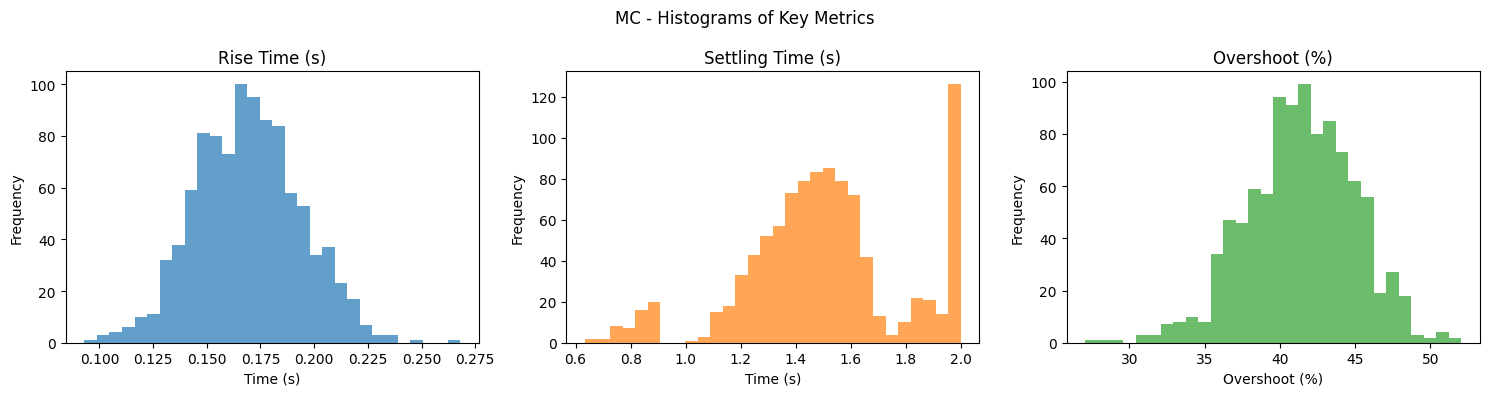

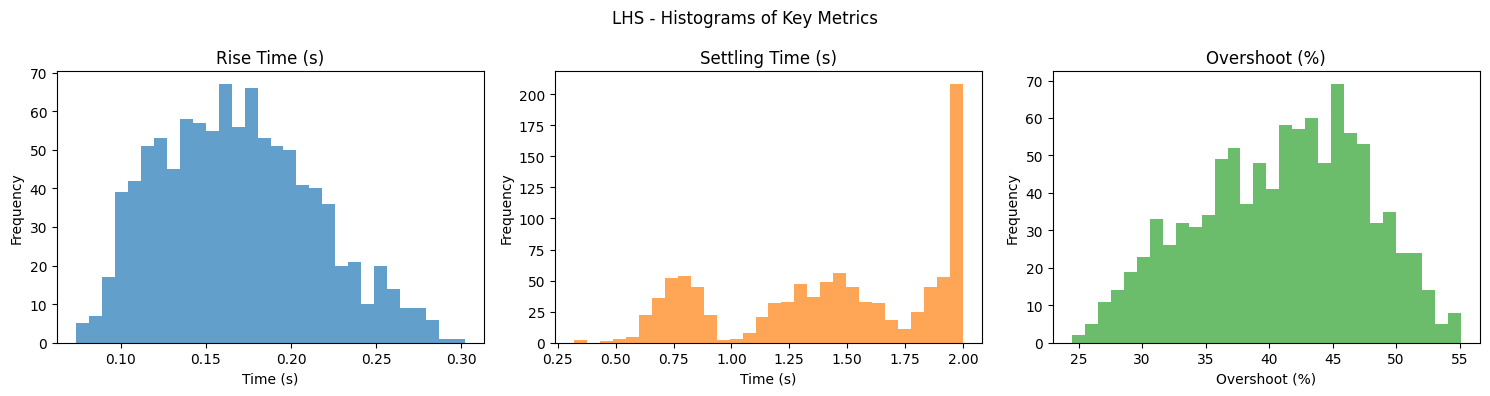

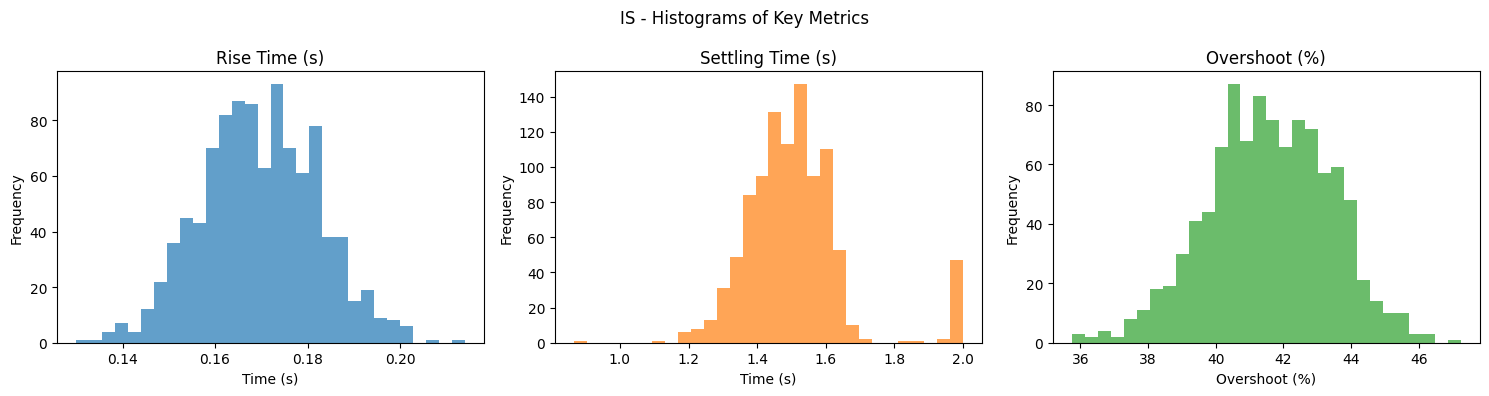

In [3]:
# Suppose we already did:
# results, t_eval = run_simulations(n_samples=1000)

plot_histograms_of_metrics(results, t_eval)

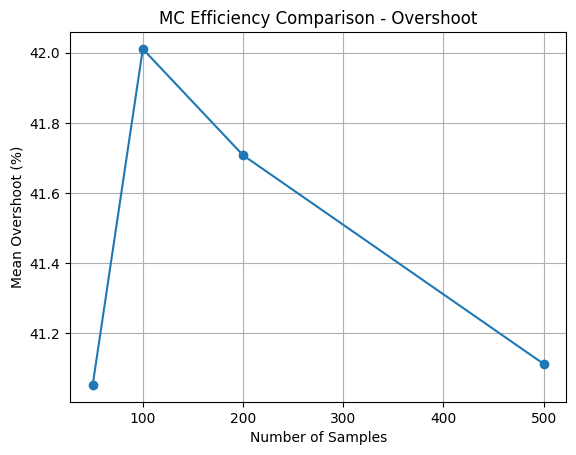

In [4]:
def efficiency_comparison(sample_sizes=[50,100,200,500,1000], method='MC'):
    """
    Compare how quickly the mean of 'overshoot' metric converges
    under a chosen sampling method.
    """
    mean_overshoot_list = []
    
    for n in sample_sizes:
        # 1) Generate parameters
        if method == 'MC':
            samples = sample_parameters_mc(n)
        elif method == 'LHS':
            samples = sample_parameters_lhs(n)
        else:
            samples = sample_parameters_is(n)
        
        # 2) Simulate each sample
        overshoot_vals = []
        for i in range(n):
            R, L, Kb, Kt, J, B = samples[i]
            sim = DCMotorSimulator(R, L, Kb, Kt, J, B)
            t, omega = sim.simulate_step_response()
            metrics = sim.compute_performance_metrics(t, omega)
            overshoot_vals.append(metrics['Peak Overshoot (%)'])
        
        # 3) Compute average overshoot across n samples
        avg_overshoot = np.mean(overshoot_vals)
        mean_overshoot_list.append(avg_overshoot)
    
    # Plot how the average overshoot changes with sample size
    plt.figure()
    plt.plot(sample_sizes, mean_overshoot_list, marker='o')
    plt.title(f'{method} Efficiency Comparison - Overshoot')
    plt.xlabel('Number of Samples')
    plt.ylabel('Mean Overshoot (%)')
    plt.grid(True)
    plt.show()
    
    return sample_sizes, mean_overshoot_list

# Example usage:
if __name__ == '__main__':
    efficiency_comparison(sample_sizes=[50,100,200,500], method='MC')
